In [1]:
import xarray as xr
import scipy as sp
from scipy import ndimage
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import f1_score as f1
from sklearn.metrics import jaccard_score as jacc
from sklearn.metrics import mean_squared_error as mse
import skimage.io as io
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import os
sns.set()

In [2]:
all_data = xr.load_dataarray(r'C:\Users\vovam\Desktop\rotations\Leeat Keren\data\all_data.nc')

In [3]:
l1_3to7 = torch.load(r'Z:\vovam\Vova\outputs\2021-05-18\13-22-23\x_hat\iter530000_0.16.pt',map_location=torch.device('cpu'))
l1_3to7 = l1_3to7.detach().numpy().squeeze()

reg_2 = torch.load(r'Z:\vovam\Vova\outputs\2021-05-12\12-21-36\x_hat\iter127500_0.25.pt',map_location=torch.device('cpu'))
reg_2 = reg_2.detach().numpy().squeeze()

In [4]:
def print_scores(scores, channels, ch_range):
    new_metric = np.zeros([1,ch_range])
    for i, chname in enumerate(channels):
        new_metric[0,i] = scores[0][0][i]/(scores[1][0][i]*100)
        print('For ch {}_{}'.format(i, chname))
        print('The f1 score is {:.2f} rmse is {:.6f} new metric {:.2f} '.format(scores[0][0][i], scores[1][0][i], new_metric[0,i]))
    #plt.scatter(preprocessing.normalize(scores[0]),preprocessing.normalize(new_metric))
    #return(new_metric)

In [5]:
def get_scores(p_true, p_hat, point_name,channels):
    
    ch_range = len(channels)
    f1scores = np.zeros([1,ch_range])
    rmsescores = np.zeros([1,ch_range])
    falsepositive = np.zeros([1,ch_range])
    falsenegative = np.zeros([1,ch_range])
    #sum_signal = np.zeros([1,ch_range])
    #binary_sum = np.zeros([1,ch_range])
    for i,chname in enumerate(channels):

        true_data = p_true.sel(fovs=[point_name], channels = chname)
        true_data = true_data.values.squeeze().flatten()
        
        hat_data = p_hat[i,:,:].squeeze().flatten()
        hat_data = np.rint(hat_data)
        hat_data = hat_data.clip(min=0)
        
        #io.imsave(f'permut_experiments/pictures/scores_5_{i}_{chname}.tif', hat_data.reshape((2048,2048)), check_contrast=False)

        binary_true = 1 * (true_data > 0)
        binary_hat = 1 *(hat_data > 0)
        
        falsepositive[0,i] = sum((binary_hat - binary_true) == 1) / len(binary_hat)
        falsenegative[0,i] = sum((binary_hat - binary_true) == -1) / len(binary_hat)
        f1scores[0,i] = f1(binary_true,binary_hat)
        rmsescores[0,i] = mse(true_data, hat_data, squared = False)/np.linalg.norm(true_data, ord=None, axis=None, keepdims=False)
        #sum_signal[0,i] = sum(true_data)
        #binary_sum[0,i] = sum(binary_true) 
        
    return(f1scores, rmsescores, falsepositive, falsenegative)
        
        

In [6]:
def save_pics(data, prefix, channels, path):
     
    for i,chname in enumerate(channels):
        pic_data = data[i,:,:].squeeze().flatten()
        pic_data = np.rint(pic_data)
        pic_data = pic_data.clip(min=0)
        pic_name = '{}_00{}_{}.tif'.format(prefix,i,chname)
        io.imsave(os.path.join(path,pic_name), pic_data.reshape((2048,2048)), check_contrast=False)


In [7]:
with open(r'Z:\vovam\Vova\data\matrices\3_7_og\channels.txt') as f:
    ch_list = f.read().split('\n')

In [8]:
path = r'C:\Users\vovam\Desktop\rotations\Leeat Keren\pictures and results\3to7\pictures'
save_pics(l1_3to7, '3to7_params', ch_list, path)

In [9]:
scores = get_scores(all_data, l1_3to7,'Point5',ch_list)
#print_scores(standart, ch_list,len(ch_list))
#scores_2 = get_scores(all_data, reg_2,'Point5',ch_list)


In [10]:
scores_df = pd.DataFrame({'F1':scores[0][0],'RMSE':scores[1][0],'FalsePos':scores[2][0],'FalseNeg':scores[3][0]}
                         ,index = ch_list)

scores_df = pd.read_csv(r'C:\Users\vovam\Desktop\rotations\Leeat Keren\training_metrics\reg_experiments\reg_experiments.csv'
                        ,index_col = 0 )
scores_df.loc[:,'Reg1F1'] = scores_1[0][0]
scores_df.loc[:, 'Reg1RMSE'] = scores_1[1][0]
scores_df.loc[:,'FalsePosReg1'] = scores_1[2][0]
scores_df.loc[:, 'FalseNegReg1'] = scores_1[3][0]
scores_df.loc[:,'Reg2F1'] = scores_2[0][0]
scores_df.loc[:, 'Reg2RMSE'] = scores_2[1][0]
scores_df.loc[:,'FalsePosReg2'] = scores_2[2][0]
scores_df.loc[:, 'FalseNegReg2'] = scores_2[3][0]

In [11]:
scores_df
scores_df.to_csv(r'C:\Users\vovam\Desktop\rotations\Leeat Keren\pictures and results\3to7\scores_19_05hyperparams.csv', index = True)

In [12]:
scores_df

,F1,RMSE,FalsePos,FalseNeg
Ki67,0.000634,0.000492,0.000177,0.005834
CD68,0.238861,0.000410,0.000452,0.071025
CD8,0.150850,0.000455,0.002656,0.039587
CD20,0.034253,0.000850,0.004934,0.001116
Pan-Keratin,0.774882,0.000321,0.049480,0.000464
HLA-DR,0.975362,0.000091,0.009166,0.001171
dsDNA,0.995778,0.000016,0.004560,0.000690


<AxesSubplot:>

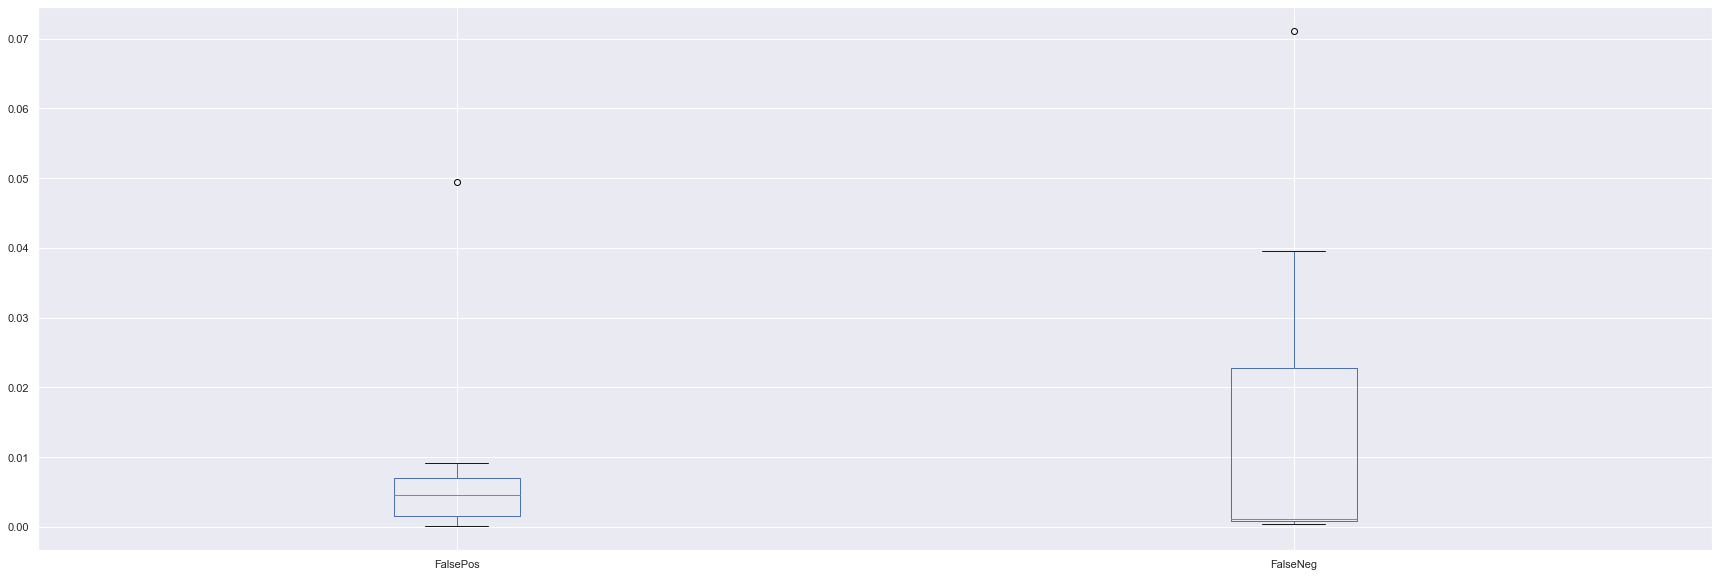

In [13]:
scores_df.loc[:,['FalsePos','FalseNeg']].plot.box(figsize=(30, 10))

<BarContainer object of 7 artists>

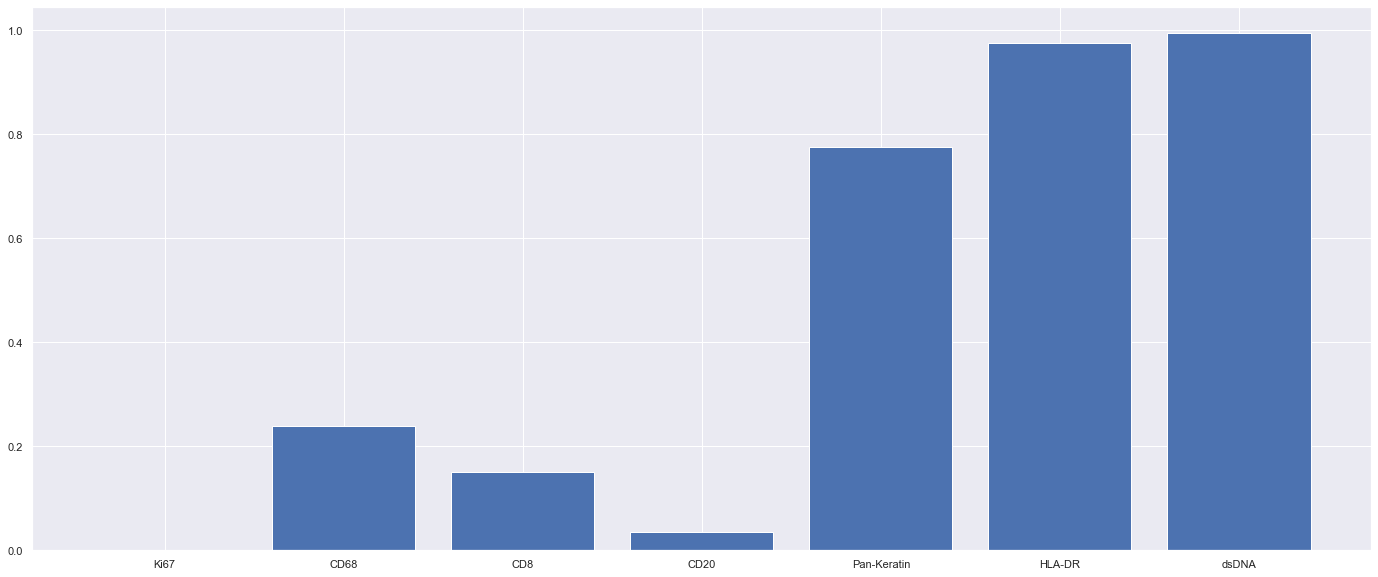

In [14]:
plt.figure(figsize=(24, 10))
plt.bar(ch_list,scores[0][0]) #- scores[2][0] - scores[3][0])

plt.figure(figsize=(24, 10))
plt.bar(ch_list,scores_2[0][0] - scores_2[2][0] - scores_2[3][0])

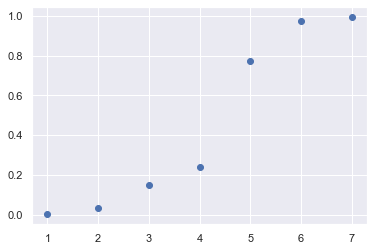

In [15]:
plt.scatter(range(1,8),sorted(list(scores[0][0]))) #- scores[2][0] - scores[3][0])))

plt.scatter(range(1,26),sorted(list(scores_2[0][0] - scores_2[2][0] - scores_2[3][0])))

In [17]:
from sklearn.metrics import auc
ys = scores[0][0]# - scores[2][0] - scores[3][0]
print('computed AUC using sklearn.metrics.auc: {}'.format(auc(range(1,8),ys)))

computed AUC using sklearn.metrics.auc: 2.672413413669762


ys = scores_2[0][0] - scores_2[2][0] - scores_2[3][0]
print('computed AUC using sklearn.metrics.auc: {}'.format(auc(range(1,26),ys)))